# 🚗 Model Predictive Control (MPC) — Double Integrator

This notebook demonstrates **basic Model Predictive Control (MPC)** on a double integrator system,
following the style of Steve Brunton’s lectures.

We will:
1. Define the system dynamics (double integrator).
2. Implement MPC using **cvxpy** (optimization-based).
3. Implement MPC using **matrix algebra** (QP formulation).
4. Compare results (position, velocity, control input).

MPC works by predicting the future trajectory, solving an optimization problem, and applying the first input (receding horizon control).

## 1. System Dynamics

We use the **discrete-time double integrator** model:
$[
x_{k+1} = A x_k + B u_k
$]
with:
$[
A = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix}, \quad 
B = \begin{bmatrix} 0.5 dt^2 \\ dt \end{bmatrix}
$]
- State: $x = [position, velocity]^T$
- Control: $u =$ acceleration input

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

# Parameters
dt = 0.1   # time step
N = 10     # prediction horizon
nx = 2     # state dimension
nu = 1     # input dimension

A = np.array([[1, dt], [0, 1]])
B = np.array([[0.5*dt**2], [dt]])

# Simulation settings
steps = 50
x0 = np.array([0, 0])  # initial state
xref = np.array([10, 0])  # target state (position=10, velocity=0)
umax = 1.0

## 2. MPC with CVXPY (Optimization Formulation)

We minimize the cost function:
$[
J = \sum_{i=0}^{N-1} (x_i - x_{ref})^T Q (x_i - x_{ref}) + u_i^T R u_i
$]
subject to dynamics and input constraints.

In [2]:
# Cost weights
Q = np.diag([1.0, 0.1])
R = np.array([[0.01]])

# Storage
x_hist = [x0]
u_hist = []

x = x0.copy()
for t in range(steps):
    # Define optimization variables
    X = cp.Variable((nx, N+1))
    U = cp.Variable((nu, N))

    cost = 0
    constr = [X[:,0] == x]
    for k in range(N):
        cost += cp.quad_form(X[:,k] - xref, Q) + cp.quad_form(U[:,k], R)
        constr += [X[:,k+1] == A @ X[:,k] + B @ U[:,k],
                   cp.abs(U[:,k]) <= umax]
    # Terminal cost
    cost += cp.quad_form(X[:,N] - xref, Q)

    # Solve optimization
    prob = cp.Problem(cp.Minimize(cost), constr)
    prob.solve(solver=cp.OSQP, verbose=False)

    u_opt = U[:,0].value
    x = A @ x + B @ u_opt

    x_hist.append(x)
    u_hist.append(u_opt)

x_hist = np.array(x_hist)
u_hist = np.array(u_hist)

### Results (CVXPY)
- Position and velocity should converge to the reference.
- Control input remains within bounds.

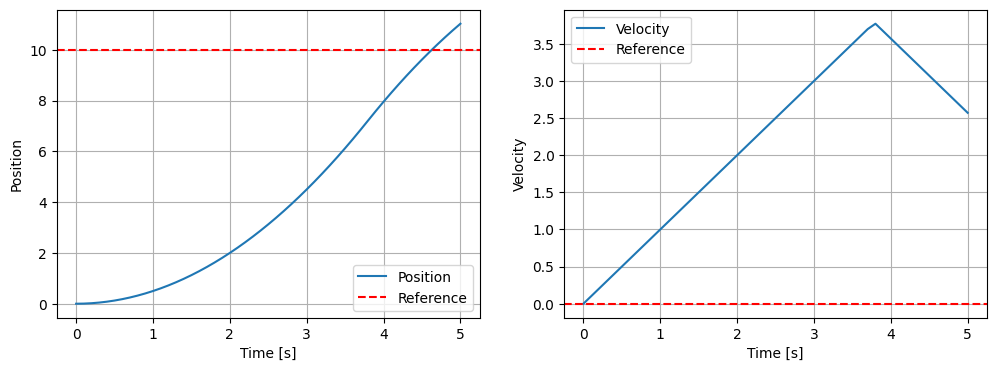

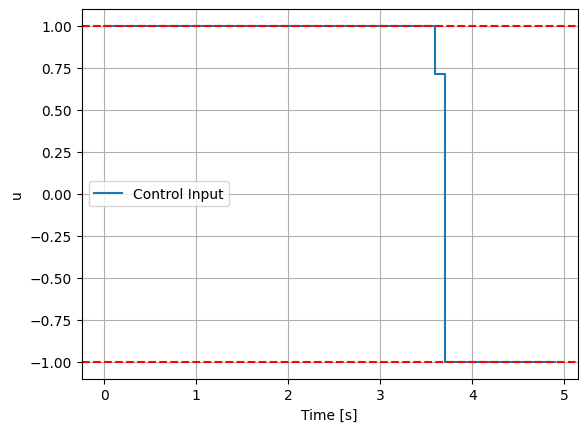

In [3]:
time = np.arange(steps+1)*dt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, x_hist[:,0], label="Position")
plt.axhline(xref[0], color='r', linestyle='--', label="Reference")
plt.xlabel('Time [s]'); plt.ylabel('Position')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time, x_hist[:,1], label="Velocity")
plt.axhline(xref[1], color='r', linestyle='--', label="Reference")
plt.xlabel('Time [s]'); plt.ylabel('Velocity')
plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.step(np.arange(steps)*dt, u_hist, label="Control Input")
plt.axhline(umax, color='r', linestyle='--')
plt.axhline(-umax, color='r', linestyle='--')
plt.xlabel('Time [s]'); plt.ylabel('u')
plt.legend(); plt.grid(True)
plt.show()

## 3. MPC with Matrix Algebra (QP Formulation)
We now derive the MPC in compact form:
$[
X = A_{bar} x_0 + B_{bar} U
$]
and solve the quadratic program:
$[
\min_U \; \tfrac{1}{2} U^T H U + f^T U
$]
This avoids calling a solver each time and is faster for real-time use.

In [13]:
def build_prediction_matrices(A, B, N):
    nx, nu = B.shape[0], B.shape[1]
    A_bar = np.zeros((nx*(N+1), nx))
    B_bar = np.zeros((nx*(N+1), nu*N))
    for i in range(N+1):
        A_bar[i*nx:(i+1)*nx,:] = np.linalg.matrix_power(A, i)
        for j in range(i):
            B_bar[i*nx:(i+1)*nx, j*nu:(j+1)*nu] = np.linalg.matrix_power(A, i-1-j) @ B
    return A_bar, B_bar

A_bar, B_bar = build_prediction_matrices(A, B, N)

# Build Q_bar, R_bar
Q_bar = np.kron(np.eye(N+1), Q)
R_bar = np.kron(np.eye(N), R)

H = B_bar.T @ Q_bar @ B_bar + R_bar

def mpc_step(x0, xref):
    f = (A_bar @ x0 - np.tile(xref, N+1))
    f = B_bar.T @ Q_bar @ f
    U = -np.linalg.solve(H, f)
    return U[:nu]

# Simulation
x = x0.copy()
x_hist2, u_hist2 = [x], []
for t in range(steps):
    u = mpc_step(x, xref)
    x = A @ x + B @ u
    x_hist2.append(x)
    u_hist2.append(u)

x_hist2 = np.array(x_hist2)
u_hist2 = np.array(u_hist2)

### Results (Matrix Form MPC)

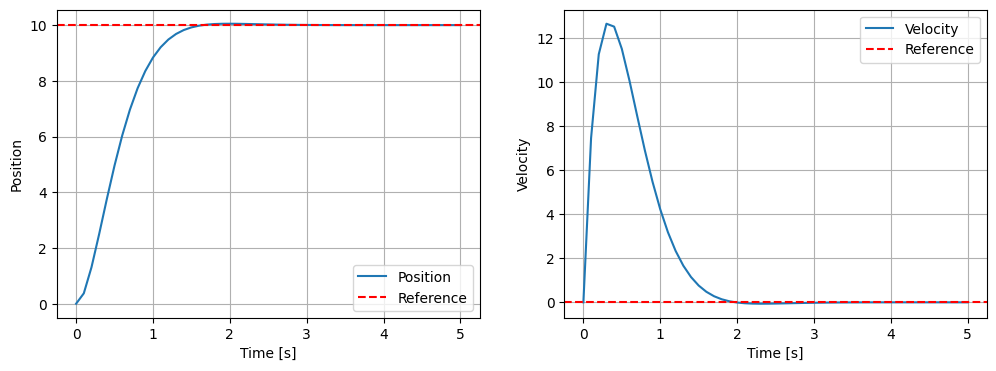

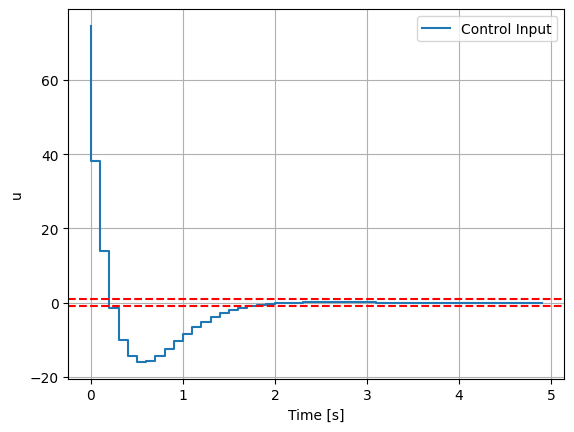

In [14]:
time = np.arange(steps+1)*dt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(time, x_hist2[:,0], label="Position")
plt.axhline(xref[0], color='r', linestyle='--', label="Reference")
plt.xlabel('Time [s]'); plt.ylabel('Position')
plt.legend(); plt.grid(True)

plt.subplot(1,2,2)
plt.plot(time, x_hist2[:,1], label="Velocity")
plt.axhline(xref[1], color='r', linestyle='--', label="Reference")
plt.xlabel('Time [s]'); plt.ylabel('Velocity')
plt.legend(); plt.grid(True)
plt.show()

plt.figure()
plt.step(np.arange(steps)*dt, u_hist2, label="Control Input")
plt.axhline(umax, color='r', linestyle='--')
plt.axhline(-umax, color='r', linestyle='--')
plt.xlabel('Time [s]'); plt.ylabel('u')
plt.legend(); plt.grid(True)
plt.show()

## 4. Conclusion
- Both **CVXPY** and **matrix algebra** MPC successfully track the reference.
- CVXPY is intuitive but slower (good for prototyping).
- Matrix form is much faster (good for real-time control).
- MPC looks ahead and respects constraints, unlike PID.

This simple example is the basis for applying MPC to vehicles in ADAS (lane keeping, trajectory tracking).